In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import math

# first pulling in the data and viewing the first few rows.

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Check total number of rows and columns
print(df.shape[0] , df.shape[1])

51392 154


In [4]:
# Question 1: how do you break into the field?
# what we really want to focus on here is specifically the CousinEducation questions

schema_df = pd.read_csv('./survey_results_schema.csv')
schema_df.head()

condition = schema_df.Column == 'CousinEducation'
q_desc = schema_df.loc[condition, 'Question'].iloc[0]

print(q_desc)


Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?
Let's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?
Let's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which of 

In [5]:
# let's review the responses from the main df

cous_ed_vals = df['CousinEducation'].value_counts().reset_index()

cous_ed_vals.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)

print(cous_ed_vals)


                                                method  count
0    Take online courses; Buy books and work throug...    711
1                                  Take online courses    551
2                                        None of these    523
3    Take online courses; Part-time/evening courses...    479
4    Take online courses; Bootcamp; Part-time/eveni...    465
..                                                 ...    ...
730  Master's degree; Bootcamp; Part-time/evening c...      1
731  Master's degree; Part-time/evening courses; Pa...      1
732  Return to college; Participate in hackathons; ...      1
733  Master's degree; Get a job as a QA tester; Par...      1
734  Master's degree; Participate in hackathons; Pa...      1

[735 rows x 2 columns]


In [6]:
# above is messy as respondants were allowed select multiple answers it appears. Need to now get unique values and review correctly. 

def get_unique_vals(df, column, delimiter):
    '''
    df - dataframe containing the column you want to review
    column - the column within the df that you want unique values from
    '''
    unique_vals = list(set(df[column].str.split(delimiter).explode()))
    
    return unique_vals
    
unique_vals = get_unique_vals(df, 'CousinEducation', '; ')
unique_vals




# note, there is a 'nan' and Master's degree has double quotes from some reason


[nan,
 'Get a job as a QA tester',
 'Participate in hackathons',
 'None of these',
 'Participate in online coding competitions',
 'Contribute to open source',
 'Bootcamp',
 'Other',
 'Part-time/evening courses',
 'Return to college',
 'Take online courses',
 'Conferences/meet-ups',
 'Buy books and work through the exercises',
 "Master's degree"]

In [7]:
# now create function to count the unique values, properly this time

def count_unique_values(df, column_name, unique_values_list):
    # reate a dictionary to store the counts for each unique value
    value_counts_dict = {value: 0 for value in unique_values_list}

    # iterate through each cell in the specified column
    for cell in df[column_name]:
        # split the cell content based on the separator
        values_in_cell = str(cell).split(';')

        # update the counts for each unique value
        for value in values_in_cell:
            if value in value_counts_dict:
                value_counts_dict[value] += 1

    # convert the dictionary to a DataFrame for better representation
    result_df = pd.DataFrame(list(value_counts_dict.items()), columns=['Value', 'Count'])
    
    # Sort the DataFrame by 'Count' in descending order
    result_df = result_df.sort_values(by='Count', ascending=False)

    return result_df

# and test it out

counted_df = count_unique_values(df, 'CousinEducation', unique_vals)
counted_df

# This is wrong. I misunderstood and forgot in include the 'count' column need to be included for aggregation - silly!

,Value,Count
10,Take online courses,9784
9,Return to college,5017
1,Get a job as a QA tester,2545
13,Master's degree,1725
5,Contribute to open source,1703
3,None of these,604
6,Bootcamp,579
12,Buy books and work through the exercises,466
8,Part-time/evening courses,430
7,Other,403


In [8]:
# now create function to count occurrences of the unique values, properly this time
# used some udacity code here as I kept getting stuck. 

def accumulate_counts(df, method_col, count_col, unique_values_list):
    """
    Parameters:
    - df: pandas DataFrame
    - method_col: column name for methods
    - count_col: column name for counts
    - unique_values_list: list of strings

    Returns:
    - new_df: pandas DataFrame with total counts for each unique value
    """
    #new_df = pd.DataFrame({method_col: unique_values_list, 'count': 0})
    new_df = defaultdict(int)

    for method in unique_values_list:
        for idx in range(df.shape[0]):
            if str(method) in df[method_col][idx]:
                new_df[method] += int(df[count_col][idx]) #taking aggregation of 2nd column into account here
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [method_col, count_col]
    new_df.sort_values(count_col, ascending = False, inplace = True)
    return new_df


total_counted_df = accumulate_counts(cous_ed_vals, 'method', 'count', unique_vals)
total_counted_df


,method,count
9,Take online courses,15246
11,Buy books and work through the exercises,11750
7,Part-time/evening courses,7517
4,Contribute to open source,7423
5,Bootcamp,5276
10,Conferences/meet-ups,5244
8,Return to college,5017
3,Participate in online coding competitions,3610
0,Get a job as a QA tester,3376
1,Participate in hackathons,2747


In [9]:
# This looks better. Adding percentage column to show proportion

total_counted_df['percentage'] = (total_counted_df['count']/total_counted_df['count'].sum()) * 100

total_counted_df

,method,count,percentage
9,Take online courses,15246,20.943171
11,Buy books and work through the exercises,11750,16.140775
7,Part-time/evening courses,7517,10.325975
4,Contribute to open source,7423,10.196849
5,Bootcamp,5276,7.247551
10,Conferences/meet-ups,5244,7.203594
8,Return to college,5017,6.891768
3,Participate in online coding competitions,3610,4.958996
0,Get a job as a QA tester,3376,4.637554
1,Participate in hackathons,2747,3.773507


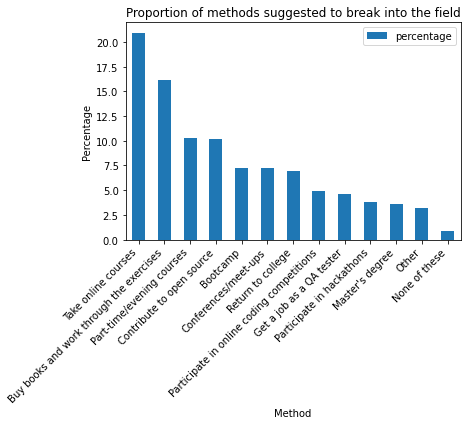

In [34]:
# now let's visualise this

total_counted_df.plot(x = 'method', y = 'percentage', kind = 'bar')
plt.xlabel('Method')
plt.ylabel('Percentage')
plt.title('Proportion of methods suggested to break into the field')
plt.xticks(rotation=45, ha='right')
plt.show()

Answer: Online courses and books are the clear favourites. Everything after that got mentioned 10% of the time or less. 



Question 2: Was there any biases in these suggestions? - did parent's education level influence the suggestion made by those surveyed?

In [11]:
#pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

df.head()
get_unique_vals(df, 'HighestEducationParents', '; ')


[nan,
 'A professional degree',
 'Primary/elementary school',
 "Some college/university study, no bachelor's degree",
 "A master's degree",
 'High school',
 'A doctoral degree',
 "A bachelor's degree",
 "I don't know/not sure",
 'No education',
 'I prefer not to answer']

In [12]:
# we now need to split these into two ategories - 1: masters, PhD, professional 2: bachelors and below. 
# we can then compare how those cohorts suggested one breaks into the field and explore whether parent's education was 
#an influence.

def parents_education(par_ed_val):
    '''
        par_ed_val: a value from the 'HighestEducationParents' column
    '''
    
    if par_ed_val in ("A master's degree", 'A doctoral degree', 'A professional degree'):
         return 1
    else:
        return 0

# test output on top 10    
df['HighestEducationParents'].apply(parents_education)[:10]
        

0    0
1    1
2    1
3    1
4    0
5    0
6    1
7    1
8    0
9    1
Name: HighestEducationParents, dtype: int64

In [13]:
# add new 'ParentEd' column as our flag

df['ParentEd'] = df['HighestEducationParents'].apply(parents_education)

# splitting the original df based on this category
parent_ed_1 = df[df['ParentEd'] == 1]
parent_ed_0 = df[df['ParentEd'] == 0]

# sense check
print(parent_ed_1['ParentEd'][:10])
print(parent_ed_1.shape, parent_ed_0.shape)

1     1
2     1
3     1
6     1
7     1
9     1
13    1
15    1
17    1
19    1
Name: ParentEd, dtype: int64
(11167, 155) (40225, 155)


In [14]:
parent_ed_0['CousinEducation'].shape

(40225,)

In [15]:
#Now let's use the functions from Q1 to get the counts of suggested method for both groups and then we can compare

# first we need to get the raw counts with the new df's above

raw_count_1 = parent_ed_1['CousinEducation'].value_counts().reset_index()
raw_count_1.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)
#print(cous_ed_vals)

raw_count_0 = parent_ed_0['CousinEducation'].value_counts().reset_index()
raw_count_0.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)
#print(cous_ed_vals)

# now use our accumulate_counts function to get the real counts

real_count_1 = accumulate_counts(raw_count_1, 'method', 'count', unique_vals)
real_count_1.set_index('method', inplace=True) # so we can merge dfs easily
perc_real_count_1 = real_count_1/real_count_1.sum()
real_count_0 = accumulate_counts(raw_count_0, 'method', 'count', unique_vals)
real_count_0.set_index('method', inplace=True)
perc_real_count_0 = real_count_0/real_count_0.sum()

#print(real_count_0)

comp_df = pd.merge(perc_real_count_1, perc_real_count_0, left_index=True, right_index=True)
comp_df.columns = ['parent_ed_1', 'parent_ed_0']
comp_df['Diff'] = comp_df['parent_ed_1'] - comp_df['parent_ed_0']
display(comp_df.style.bar(subset=['Diff'], align='mid', color=['#d65f5f', '#5fba7d']))


,parent_ed_1,parent_ed_0,Diff
method,,,
Take online courses,0.205850,0.210798,-0.004948
Buy books and work through the exercises,0.160979,0.161571,-0.000592
Contribute to open source,0.106606,0.100199,0.006407
Part-time/evening courses,0.096956,0.105665,-0.008709
Bootcamp,0.075415,0.071354,0.004061
Return to college,0.070292,0.068394,0.001898
Conferences/meet-ups,0.067058,0.073935,-0.006877
Get a job as a QA tester,0.046961,0.046152,0.000808
Participate in online coding competitions,0.046165,0.050897,-0.004732


The biggest difference is in suggestions of master's degrees with just under 1%.
Developers with Parents who are educated with higher education are ~33% more likely to suggest using formal higher educaiton as a means of breaking into the field. 

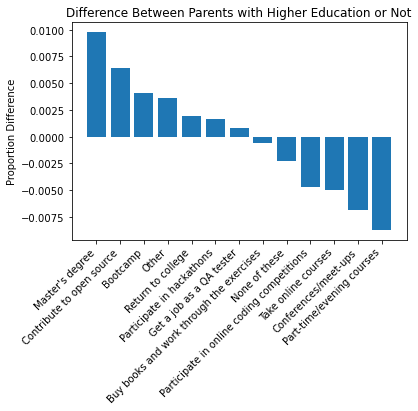

In [39]:
# let's make a simpler/clearer graph to show results

comp_df_sorted = comp_df.sort_values(by='Diff', ascending=False)

plt.bar(comp_df_sorted.index, comp_df_sorted['Diff'])
plt.ylabel('Proportion Difference')
plt.title('Difference Between Parents with Higher Education or Not')
plt.xticks(comp_df_sorted.index, rotation=45, ha='right')
plt.show()

In [16]:


#let's look at potential bias

masters_overall_pop = 3.625149
masters_par_ed_pop = 4.3329

bias_ratio = masters_par_ed_pop/masters_overall_pop

bias_ratio
# gives us 1.1952


1.1952336303969853

Answer: when comparing the two populations, 'master's degree' does give us the bggest difference in occurrence 
which is interesting. However the difference is not that big ~ 1%.

In [17]:
#Question 3: exploring the most popular languages/tools that those in the profession have. i.e. potentially the 
#most valuable to learn for those looking to enter the field
# 1 - filter df by those who are professional coders, 2 - explore relvant columns about languages and tools

pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

df.head()



,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary,ParentEd
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.0,Desktop; iOS ap

In [20]:
condition = schema_df.Column == 'Professional'
q_desc = schema_df.loc[condition, 'Question'].iloc[0]

print(q_desc)

Which of the following best describes you?


In [21]:
prof_unique_vals = df['Professional'].value_counts().reset_index()
prof_unique_vals

,index,Professional
0,Professional developer,36131
1,Student,8224
2,Professional non-developer who sometimes write...,5140
3,Used to be a professional developer,983
4,None of these,914


In [22]:
employment_unique_vals = df['EmploymentStatus'].value_counts().reset_index()
employment_unique_vals

,index,EmploymentStatus
0,Employed full-time,36148
1,"Independent contractor, freelancer, or self-em...",5233
2,Employed part-time,3180
3,"Not employed, and not looking for work",2791
4,"Not employed, but looking for work",2786
5,I prefer not to say,1086
6,Retired,168


As our working dataframe, I'm going to filter the original df by those who are a) professional programmers and b) currently employed. This is because the perspective of this analysis is gaining insight for those who want to enter the industry currently.

In [23]:
q3_df = df[(df['EmploymentStatus'] == 'Employed full-time') & (df['Professional'] == 'Professional developer')]

q3_df.shape


(30211, 155)

In [24]:
# We have our working dataframe now, let's explore the columns about languages used. 

lang_val_counts_messy = df['HaveWorkedLanguage'].value_counts().reset_index()
lang_val_counts_messy.rename(columns={'index': 'language', 'HaveWorkedLanguage': 'count'}, inplace=True)
lang_val_counts_messy

,language,count
0,C#; JavaScript; SQL,1276
1,JavaScript; PHP; SQL,1143
2,Java,913
3,JavaScript,807
4,JavaScript; PHP,662
...,...,...
8433,C++; C#; CoffeeScript; Java; JavaScript; PHP,1
8434,R; Scala; SQL,1
8435,C#; Erlang; F#; JavaScript; SQL,1
8436,C#; F#; JavaScript; Objective-C; SQL; Swift,1


In [25]:
# looks like a job for .... get_unique_vals and accumulate_counts!!!!!

lang_unique_vals = get_unique_vals(q3_df, 'HaveWorkedLanguage', '; ')
lang_unique_vals

[nan,
 'C',
 'C#',
 'Dart',
 'Haskell',
 'Smalltalk',
 'Objective-C',
 'Assembly',
 'TypeScript',
 'Go',
 'Perl',
 'JavaScript',
 'Ruby',
 'Clojure',
 'Groovy',
 'Hack',
 'F#',
 'Lua',
 'Java',
 'PHP',
 'CoffeeScript',
 'C++',
 'Matlab',
 'Rust',
 'Scala',
 'Visual Basic 6',
 'Elixir',
 'R',
 'Common Lisp',
 'VB.NET',
 'SQL',
 'Python',
 'Julia',
 'VBA',
 'Swift',
 'Erlang']

In [26]:
lang_val_counts = accumulate_counts(lang_val_counts_messy, 'language', 'count', lang_unique_vals)
lang_val_counts

,language,count
17,Java,28149
10,JavaScript,22875
0,C,21173
29,SQL,18754
1,C#,12476
30,Python,11704
18,PHP,10290
20,C++,8155
26,R,5051
7,TypeScript,3488


In [27]:
lang_val_counts['percentage'] = (lang_val_counts['count']/lang_val_counts['count'].sum()) * 100

lang_val_counts

,language,count,percentage
17,Java,28149,16.567494
10,JavaScript,22875,13.463406
0,C,21173,12.461670
29,SQL,18754,11.037933
1,C#,12476,7.342927
30,Python,11704,6.888555
18,PHP,10290,6.056326
20,C++,8155,4.799741
26,R,5051,2.972838
7,TypeScript,3488,2.052912


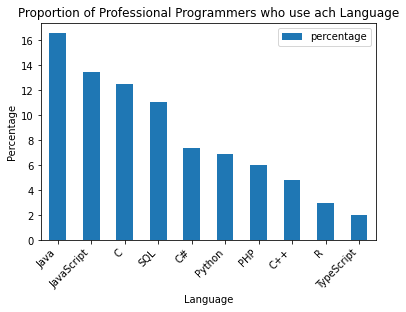

In [42]:
lang_val_counts[:10].plot(x = 'language', y = 'percentage', kind = 'bar')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.title('Proportion of Professional Programmers who use ach Language')
plt.xticks(rotation=45, ha='right')
plt.show()

# maybe let's do a cutoff and get rid of those below 2 % to make this a bit clearer. The top ones are the focus after all

Answer: Java is the most common, while javascript, C and SQL are all used by at least 10% of the current professional programmers surveyed. 